**"Taco Sales Forecasting & Insights Dashboard "**

**Objective**
Build and deliver a forecasting and analytics solution for taco sales to help a fictional restaurant chain optimize inventory planning, pricing, and promotion strategies.


**Data Ingestion & Cleaning**
-Load and explore the taco sales dataset using Python (e.g., pandas).
-Handle missing values, seasonal patterns, price variations, and any anomalies.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 120)
print("Versions -> pandas:", pd.__version__, "| numpy:", np.__version__)

In [ ]:
# Load the dataset
file_path = '/content/1754847663488_a2240d37cc (2).csv'
df_raw = pd.read_csv(file_path)
print("Shape:", df_raw.shape)
display(df_raw.head())
display(df_raw.sample(5, random_state=42))
print("\nDtypes:")
print(df_raw.dtypes)
print("\nNull counts:")
print(df_raw.isna().sum())


Shape: (1000, 13)


,Order ID,Restaurant Name,Location,Order Time,Delivery Time,Delivery Duration (min),Taco Size,Taco Type,Toppings Count,Distance (km),Price ($),Tip ($),Weekend Order
0,770487,El Taco Loco,New York,01-08-2024 14:55,01-08-2024 15:36,41,Regular,Chicken Taco,5,3.01,9.25,2.22,False
1,671858,El Taco Loco,San Antonio,23-11-2024 17:11,23-11-2024 17:25,14,Regular,Beef Taco,1,6.20,4.25,3.01,True
2,688508,Taco Haven,Austin,21-11-2024 20:24,21-11-2024 21:02,38,Large,Pork Taco,2,20.33,7.00,0.02,False
3,944962,Spicy Taco House,Dallas,21-09-2024 06:43,21-09-2024 07:28,45,Regular,Chicken Taco,2,3.00,5.50,1.90,True
4,476417,Casa del Taco,San Antonio,24-07-2024 11:01,24-07-2024 11:16,15,Large,Pork Taco,0,24.34,4.50,1.14,False


,Order ID,Restaurant Name,Location,Order Time,Delivery Time,Delivery Duration (min),Taco Size,Taco Type,Toppings Count,Distance (km),Price ($),Tip ($),Weekend Order
521,687569,The Taco Stand,Phoenix,24-09-2024 07:14,24-09-2024 07:26,12,Large,Beef Taco,2,21.75,7.00,2.89,False
737,583439,Spicy Taco House,San Diego,06-05-2024 20:17,06-05-2024 20:33,16,Large,Veggie Taco,3,16.09,8.25,2.87,False
740,243601,The Taco Stand,Phoenix,16-10-2024 17:29,16-10-2024 18:41,72,Large,Veggie Taco,1,3.01,5.75,0.46,False
660,134697,Casa del Taco,Los Angeles,22-04-2024 16:18,22-04-2024 17:44,86,Regular,Fish Taco,3,19.37,6.75,0.71,False
411,869735,Taco Fiesta,San Antonio,26-01-2025 23:03,26-01-2025 23:34,31,Regular,Veggie Taco,5,16.44,9.25,0.19,True



Dtypes:
Order ID                     int64
Restaurant Name             object
Location                    object
Order Time                  object
Delivery Time               object
Delivery Duration (min)      int64
Taco Size                   object
Taco Type                   object
Toppings Count               int64
Distance (km)              float64
Price ($)                  float64
Tip ($)                    float64
Weekend Order                 bool
dtype: object

Null counts:
Order ID                   0
Restaurant Name            0
Location                   0
Order Time                 0
Delivery Time              0
Delivery Duration (min)    0
Taco Size                  0
Taco Type                  0
Toppings Count             0
Distance (km)              0
Price ($)                  0
Tip ($)                    0
Weekend Order              0
dtype: int64


In [ ]:
# Parse day-first timestamps observed in the file (e.g., '21-11-2024 20:24')
df = df_raw.copy()
for col in ["Order Time", "Delivery Time"]:
    df[col] = pd.to_datetime(df[col], dayfirst=True, errors="coerce")

# Basic derived fields
df["order_date"] = df["Order Time"].dt.date
df["order_dt"]   = df["Order Time"].dt.floor("T")
df["delivery_dt"]= df["Delivery Time"].dt.floor("T")
df["order_hour"] = df["Order Time"].dt.hour
df["order_dow"]  = df["Order Time"].dt.dayofweek  # 0=Mon, 6=Sun
df["order_month"]= df["Order Time"].dt.month
df["is_weekend_calc"] = df["order_dow"].isin([5,6])

# Delivery duration recompute (minutes) to validate given values
df["delivery_duration_calc_min"] = (df["Delivery Time"] - df["Order Time"]).dt.total_seconds() / 60.0

# Sanity checks
print("Any negative distances?", (df["Distance (km)"] < 0).any())
print("Any negative prices?", (df["Price ($)"] < 0).any())
print("Any negative tips?", (df["Tip ($)"] < 0).any())

# Compare provided vs calculated delivery duration
valid_duration_mask = df["Delivery Duration (min)"].notna() & df["delivery_duration_calc_min"].notna()
duration_diff = (df.loc[valid_duration_mask, "Delivery Duration (min)"] - df.loc[valid_duration_mask, "delivery_duration_calc_min"]).abs()
print("Median abs difference (provided vs calc) in minutes:", pd.Series([duration_diff.median()]).round(2)[0])

Any negative distances? False
Any negative prices? False
Any negative tips? False
Median abs difference (provided vs calc) in minutes: 0.0


/tmp/ipython-input-3341106447.py:8: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df["order_dt"]   = df["Order Time"].dt.floor("T")
/tmp/ipython-input-3341106447.py:9: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df["delivery_dt"]= df["Delivery Time"].dt.floor("T")


Handling both Numerical & Categorical Missing Values.

In [ ]:
# Separate numeric/categorical
import numpy as np
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(include=["object","category","bool"]).columns.tolist()

# Impute numeric with median
for c in num_cols:
    if df[c].isna().any():
        med = df[c].median()
        df[c] = df[c].fillna(med)

# Impute categorical with mode (most frequent)
for c in cat_cols:
    if df[c].isna().any():
        mode_val = df[c].mode(dropna=True)
        mode_val = mode_val.iloc[0] if not mode_val.empty else "Unknown"
        df[c] = df[c].fillna(mode_val)

# For time columns, if still NaT due to bad strings, drop these rows (rare)
time_na = df["Order Time"].isna() | df["Delivery Time"].isna()
if time_na.any():
    print(f"Dropping rows with unparseable timestamps: {int(time_na.sum())}")
    df = df.loc[~time_na].copy()

print("Null counts after imputation/drops:")
print(df.isna().sum())


Null counts after imputation/drops:
Order ID                      0
Restaurant Name               0
Location                      0
Order Time                    0
Delivery Time                 0
Delivery Duration (min)       0
Taco Size                     0
Taco Type                     0
Toppings Count                0
Distance (km)                 0
Price ($)                     0
Tip ($)                       0
Weekend Order                 0
order_date                    0
order_dt                      0
delivery_dt                   0
order_hour                    0
order_dow                     0
order_month                   0
is_weekend_calc               0
delivery_duration_calc_min    0
dtype: int64


Price Variations: Sanity Rules & Outlier Treatment

In [ ]:
# Enforce non-negativity
for c in ["Price ($)", "Tip ($)", "Distance (km)"]:
    df.loc[df[c] < 0, c] = np.nan
    df[c] = df[c].fillna(df[c].median())

# Basic price sanity by size (optional rules of thumb; adjust for your business rules)
# Example: Small: $2–$6, Medium: $4–$9, Large: $6–$12
bounds = {
    "Small":  (2.0, 6.0),
    "Medium": (4.0, 9.0),
    "Large":  (6.0, 12.0)
}
mask_known_size = df["Taco Size"].isin(bounds.keys())

def clip_by_size(row):
    if row["Taco Size"] in bounds:
        lo, hi = bounds[row["Taco Size"]]
        return min(max(row["Price ($)"], lo), hi)
    return row["Price ($)"]

df.loc[mask_known_size, "Price ($)"] = df.loc[mask_known_size].apply(clip_by_size, axis=1)

# Robust winsorization by IQR on numeric columns to suppress extreme anomalies
def winsorize_iqr(s, k=3.0):
    q1, q3 = s.quantile([0.25, 0.75])
    iqr = q3 - q1
    lo = q1 - k*iqr
    hi = q3 + k*iqr
    return s.clip(lower=lo, upper=hi)

for c in ["Price ($)", "Tip ($)", "Delivery Duration (min)", "Distance (km)"]:
    df[c] = winsorize_iqr(df[c], k=3.0)

# Total order value (optionally include tip)
df["order_value"] = df["Price ($)"] + df["Tip ($)"]

 Seasonal Feature Engineering

In [ ]:
# Extract cyclical/seasonal signals
df["is_weekend"] = df["Weekend Order"].astype(bool) if "Weekend Order" in df.columns else df["is_weekend_calc"]
df["dow_name"] = df["Order Time"].dt.day_name()

print(df[["order_dt","order_hour","order_dow","order_month","is_weekend","dow_name"]].head())


             order_dt  order_hour  order_dow  order_month  is_weekend   dow_name
0 2024-08-01 14:55:00          14          3            8       False   Thursday
1 2024-11-23 17:11:00          17          5           11        True   Saturday
2 2024-11-21 20:24:00          20          3           11       False   Thursday
3 2024-09-21 06:43:00           6          5            9        True   Saturday
4 2024-07-24 11:01:00          11          2            7       False  Wednesday


Aggregate to Daily Series (for Forecasting) & Reindex Missing Dates

In [ ]:
# Treat each row as an order; for quantity per order, replace 'order_count=1' with that column.
df["order_count"] = 1

daily = (
    df.set_index("order_dt")
      .sort_index()
      .resample("D")
      .agg({
          "order_count": "sum",
          "order_value": "sum",
          "Price ($)": "mean",
          "Tip ($)": "mean",
          "Distance (km)": "mean"
      })
      .rename(columns={
          "order_count": "orders",
          "order_value": "revenue",
          "Price ($)": "avg_price",
          "Tip ($)": "avg_tip",
          "Distance (km)": "avg_distance"
      })
)

# Fill missing days with zeros for counts and forward-fill for averages
daily["orders"] = daily["orders"].fillna(0).astype(int)
for c in ["revenue", "avg_price", "avg_tip", "avg_distance"]:
    daily[c] = daily[c].fillna(method="ffill")

display(daily.head(10))
print("Date span:", daily.index.min().date(), "→", daily.index.max().date())

/tmp/ipython-input-4030031847.py:27: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  daily[c] = daily[c].fillna(method="ffill")


,orders,revenue,avg_price,avg_tip,avg_distance
order_dt,,,,,
2024-01-01,1,8.77,6.000000,2.770000,1.970000
2024-01-02,1,6.71,6.000000,0.710000,13.480000
2024-01-03,0,0.00,6.000000,0.710000,13.480000
2024-01-04,3,28.22,8.833333,0.573333,14.016667
2024-01-05,3,27.51,7.583333,1.586667,10.403333
2024-01-06,5,45.49,6.650000,2.448000,14.040000
2024-01-07,2,17.62,4.875000,3.935000,14.825000
2024-01-08,4,37.50,7.375000,2.000000,21.687500
2024-01-09,4,33.00,6.812500,1.437500,17.995000


Date span: 2024-01-01 → 2025-05-24


Anomaly Detection Flags (Rolling Z-Score)

,orders,revenue,avg_price,avg_tip,avg_distance,orders_z,revenue_z,orders_anom,revenue_anom
order_dt,,,,,,,,,
2025-05-15,3,34.59,9.416667,2.113333,14.693333,0.707107,1.069001,0,0
2025-05-16,7,54.91,5.928571,1.915714,9.237143,2.534312,2.048202,0,0
2025-05-17,2,23.65,7.750000,4.075000,15.230000,-0.153811,0.120560,0,0
2025-05-18,3,35.23,8.583333,3.160000,16.380000,0.344706,0.746381,0,0
2025-05-19,3,27.61,7.666667,1.536667,13.693333,0.305681,0.242513,0,0
2025-05-20,0,0.00,7.666667,1.536667,13.693333,-1.299146,-1.412228,0,0
2025-05-21,5,53.35,8.550000,2.120000,13.636000,1.187578,1.484825,0,0
2025-05-22,1,10.18,8.250000,1.930000,22.720000,-0.827706,-0.866345,0,0
2025-05-23,2,15.21,6.000000,1.605000,21.105000,-0.287297,-0.526780,0,0


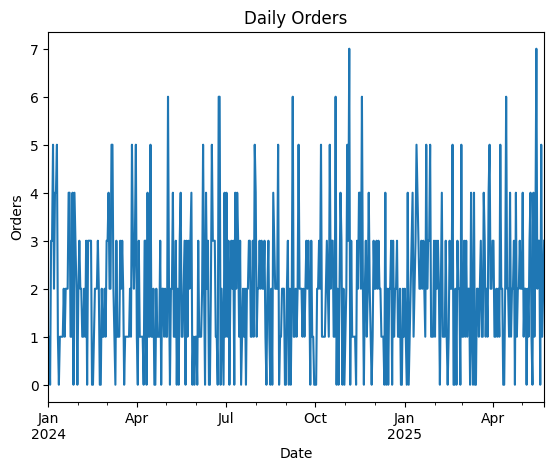

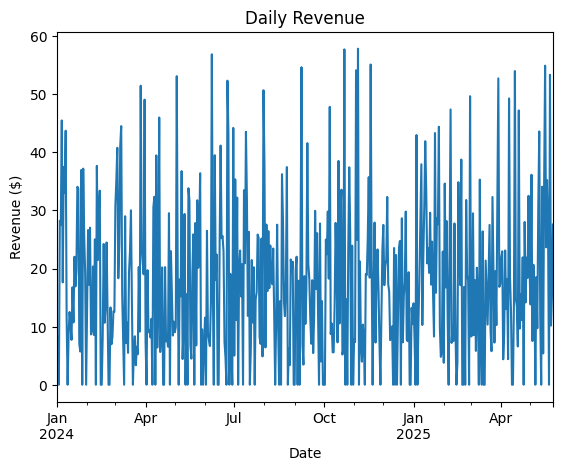

In [ ]:
# Rolling z-score to flag unusual spikes/drops in orders or revenue
def rolling_zscore(s, window=14, min_periods=7):
    mu = s.rolling(window, min_periods=min_periods).mean()
    sd = s.rolling(window, min_periods=min_periods).std()
    return (s - mu) / sd

daily["orders_z"]  = rolling_zscore(daily["orders"],  window=14)
daily["revenue_z"] = rolling_zscore(daily["revenue"], window=14)

daily["orders_anom"]  = (daily["orders_z"].abs()  >= 3).astype(int)
daily["revenue_anom"] = (daily["revenue_z"].abs() >= 3).astype(int)

display(daily.tail(10))

# Plot daily orders and revenue for a visual sense check
plt.figure()
daily["orders"].plot(title="Daily Orders")
plt.xlabel("Date")
plt.ylabel("Orders")
plt.show()

plt.figure()
daily["revenue"].plot(title="Daily Revenue")
plt.xlabel("Date")
plt.ylabel("Revenue ($)")
plt.show()


Save Cleaned Datasets

In [ ]:

CLEAN_DIR = Path("/content/cleaned")
CLEAN_DIR.mkdir(parents=True, exist_ok=True)

clean_orders_path = CLEAN_DIR / "taco_orders_clean.csv"
daily_path = CLEAN_DIR / "taco_daily_aggregated.csv"

df.to_csv(clean_orders_path, index=False)
daily.to_csv(daily_path)

print("Saved:")
print(" -", clean_orders_path)
print(" -", daily_path)

Saved:
 - /content/cleaned/taco_orders_clean.csv
 - /content/cleaned/taco_daily_aggregated.csv


In [ ]:
null_summary = (
    df.isna()
      .mean()
      .mul(100)
      .round(2)
      .rename("pct_null")
      .to_frame()
      .sort_values("pct_null", ascending=False)
)
display(null_summary.head(20))

,pct_null
Order ID,0.0
Restaurant Name,0.0
Location,0.0
Order Time,0.0
Delivery Time,0.0
Delivery Duration (min),0.0
Taco Size,0.0
Taco Type,0.0
Toppings Count,0.0
Distance (km),0.0


**Exploratory Data Analysis (EDA)**
-Visualize trends in sales volume, revenue, pricing, and day-of-week or seasonal
effects using Python (matplotlib, seaborn).

Data shape: (1000, 25)
['Order ID', 'Restaurant Name', 'Location', 'Order Time', 'Delivery Time', 'Delivery Duration (min)', 'Taco Size', 'Taco Type', 'Toppings Count', 'Distance (km)', 'Price ($)', 'Tip ($)', 'Weekend Order', 'order_date', 'order_dt', 'delivery_dt', 'order_hour', 'order_dow', 'order_month', 'is_weekend_calc', 'delivery_duration_calc_min', 'order_value', 'is_weekend', 'dow_name', 'order_count']
   Order ID   Restaurant Name     Location           Order Time        Delivery Time  Delivery Duration (min)  \
0    770487      El Taco Loco     New York  2024-08-01 14:55:00  2024-08-01 15:36:00                       41   
1    671858      El Taco Loco  San Antonio  2024-11-23 17:11:00  2024-11-23 17:25:00                       14   
2    688508        Taco Haven       Austin  2024-11-21 20:24:00  2024-11-21 21:02:00                       38   
3    944962  Spicy Taco House       Dallas  2024-09-21 06:43:00  2024-09-21 07:28:00                       45   
4    476417     Casa

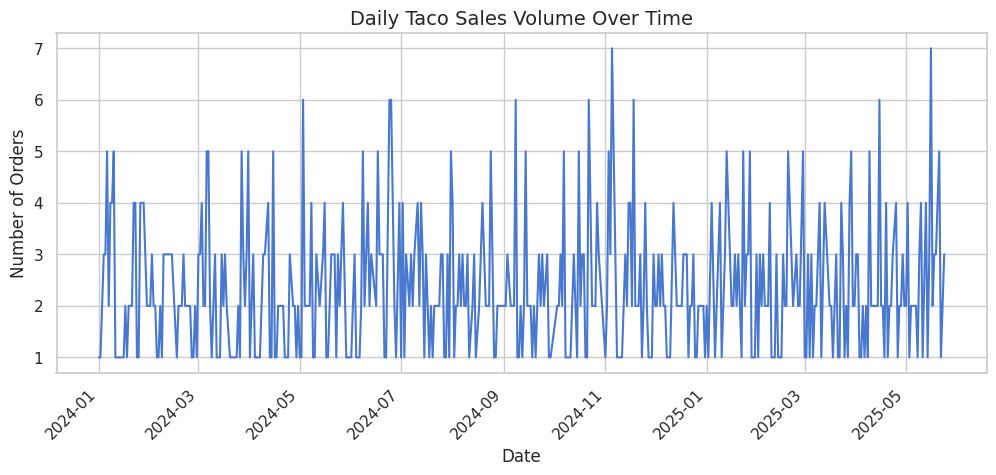

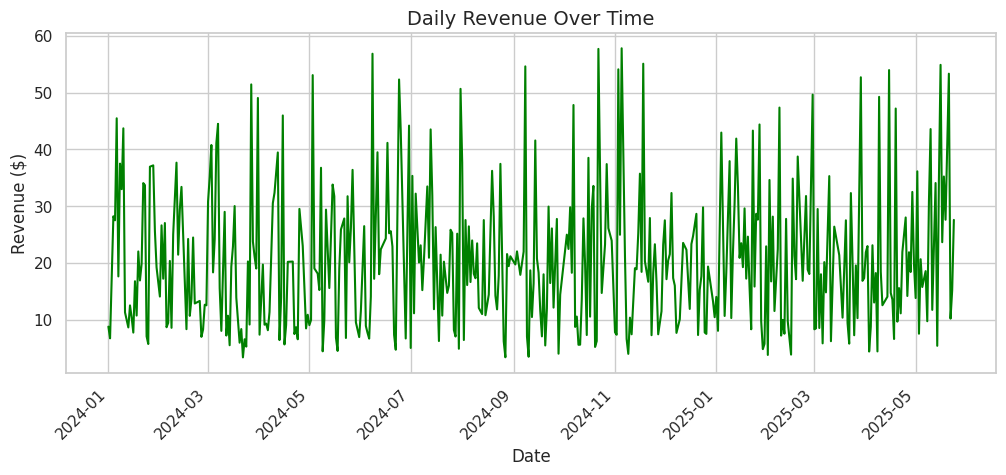

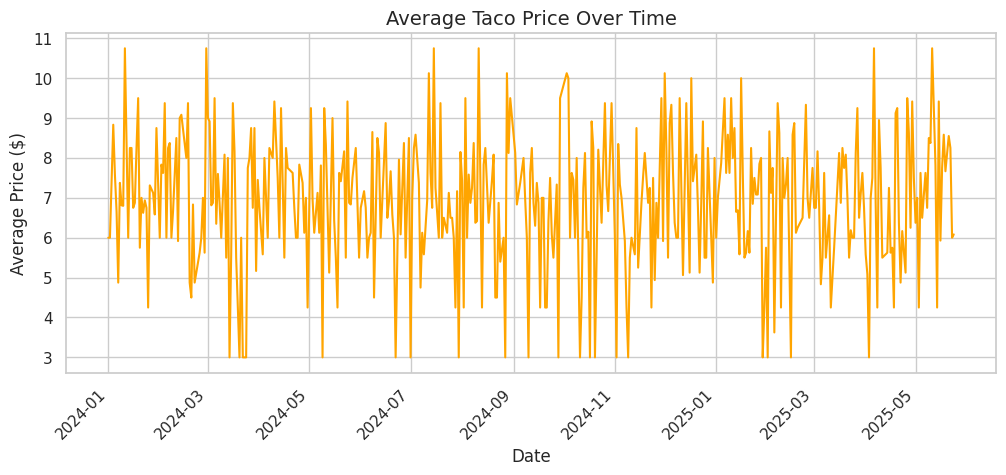

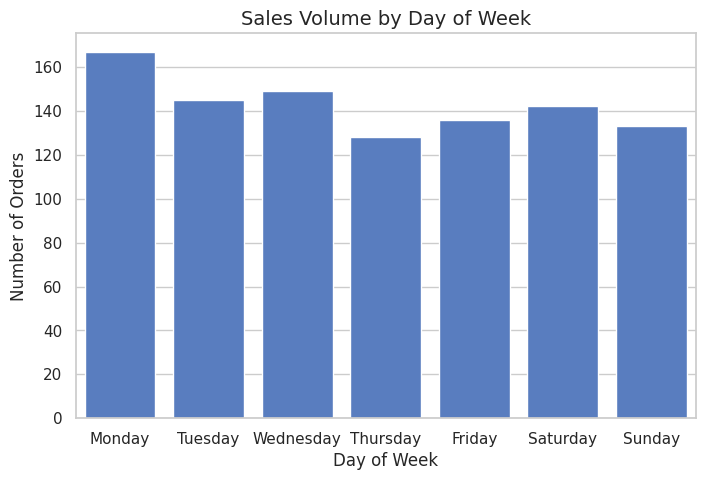

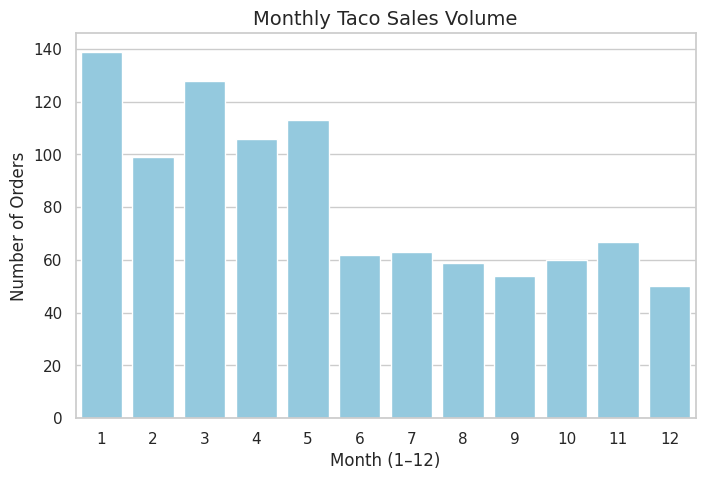

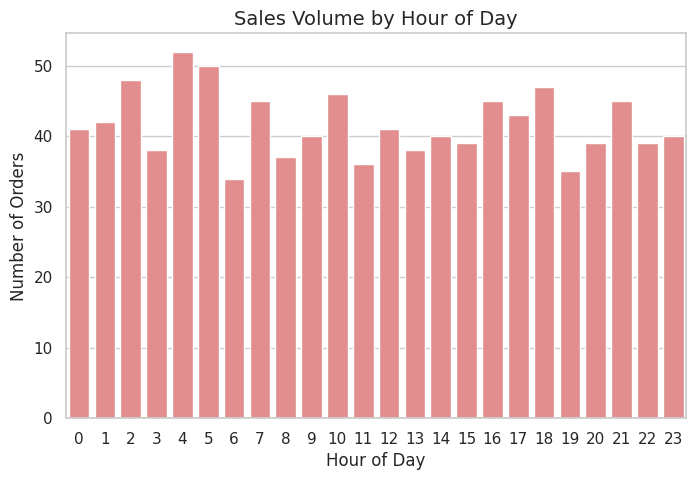

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv("/content/cleaned/taco_orders_clean.csv")


# Ensure order_date is datetime
df["order_date"] = pd.to_datetime(df["order_date"])

print(f"Data shape: {df.shape}")
print(df.columns.tolist())
print(df.head())

# Set Seaborn style
sns.set_theme(style="whitegrid", palette="muted")

# 1️⃣ Sales Volume Trend Over Time
sales_per_day = df.groupby("order_date")["Order ID"].count()

plt.figure(figsize=(12,5))
sales_per_day.plot()
plt.title("Daily Taco Sales Volume Over Time", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Number of Orders")
plt.xticks(rotation=45)
plt.show()

# 2️⃣ Revenue Trend Over Time
revenue_per_day = df.groupby("order_date")["order_value"].sum()

plt.figure(figsize=(12,5))
revenue_per_day.plot(color="green")
plt.title("Daily Revenue Over Time", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Revenue ($)")
plt.xticks(rotation=45)
plt.show()

# 3️⃣ Average Price Trend Over Time
avg_price_per_day = df.groupby("order_date")["Price ($)"].mean()

plt.figure(figsize=(12,5))
avg_price_per_day.plot(color="orange")
plt.title("Average Taco Price Over Time", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Average Price ($)")
plt.xticks(rotation=45)
plt.show()

# 4️⃣ Day-of-Week Effects on Sales
plt.figure(figsize=(8,5))
sns.barplot(
    x="dow_name",
    y="Order ID",
    data=df,
    estimator=len,
    order=["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
)
plt.title("Sales Volume by Day of Week", fontsize=14)
plt.ylabel("Number of Orders")
plt.xlabel("Day of Week")
plt.show()

# 5️⃣ Seasonal (Monthly) Effects
plt.figure(figsize=(8,5))
sns.barplot(
    x="order_month",
    y="Order ID",
    data=df,
    estimator=len,
    color="skyblue"
)
plt.title("Monthly Taco Sales Volume", fontsize=14)
plt.ylabel("Number of Orders")
plt.xlabel("Month (1–12)")
plt.show()

# 6️⃣ Hourly Sales Pattern
plt.figure(figsize=(8,5))
sns.barplot(
    x="order_hour",
    y="Order ID",
    data=df,
    estimator=len,
    color="lightcoral"
)
plt.title("Sales Volume by Hour of Day", fontsize=14)
plt.ylabel("Number of Orders")
plt.xlabel("Hour of Day")
plt.show()

Time Series Forecasting
- Develop and compare forecasting models:
- Traditional: ARIMA, SARIMA, Exponential Smoothing.
- ML-based: Random Forests or Gradient Boosting on lag features.
- Advanced: LSTM neural networks or Prophet (if suitable).
- Evaluate model performance with MAE, RMSE, and forecast accuracy metrics.

In [ ]:
!pip -q install prophet pmdarima --upgrade
!pip -q install tensorflow

import warnings, numpy as np, pandas as pd, matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (12,4)
plt.rcParams["axes.grid"] = True

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 31.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd

df_raw = pd.read_csv("/content/cleaned/taco_daily_aggregated.csv")
print(df_raw.columns)
df_raw.head()

Index(['order_dt', 'orders', 'revenue', 'avg_price', 'avg_tip', 'avg_distance', 'orders_z', 'revenue_z', 'orders_anom',
       'revenue_anom'],
      dtype='object')


,order_dt,orders,revenue,avg_price,avg_tip,avg_distance,orders_z,revenue_z,orders_anom,revenue_anom
0,2024-01-01,1,8.77,6.000000,2.770000,1.970000,NaN,NaN,0,0
1,2024-01-02,1,6.71,6.000000,0.710000,13.480000,NaN,NaN,0,0
2,2024-01-03,0,0.00,6.000000,0.710000,13.480000,NaN,NaN,0,0
3,2024-01-04,3,28.22,8.833333,0.573333,14.016667,NaN,NaN,0,0
4,2024-01-05,3,27.51,7.583333,1.586667,10.403333,NaN,NaN,0,0


DEBUG:cmdstanpy:input tempfile: /tmp/tmp30_0_mom/_ikxsfpa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp30_0_mom/l8v6ct7c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55117', 'data', 'file=/tmp/tmp30_0_mom/_ikxsfpa.json', 'init=/tmp/tmp30_0_mom/l8v6ct7c.json', 'output', 'file=/tmp/tmp30_0_mom/prophet_modelmqiyeua4/prophet_model-20250831045655.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:56:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:56:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


           Model        MAE       RMSE
0  Random Forest   1.509978   2.511117
1         SARIMA  11.757934  15.399558
2   Holt-Winters  11.853614  15.437206
3        Prophet  11.902478  15.498813


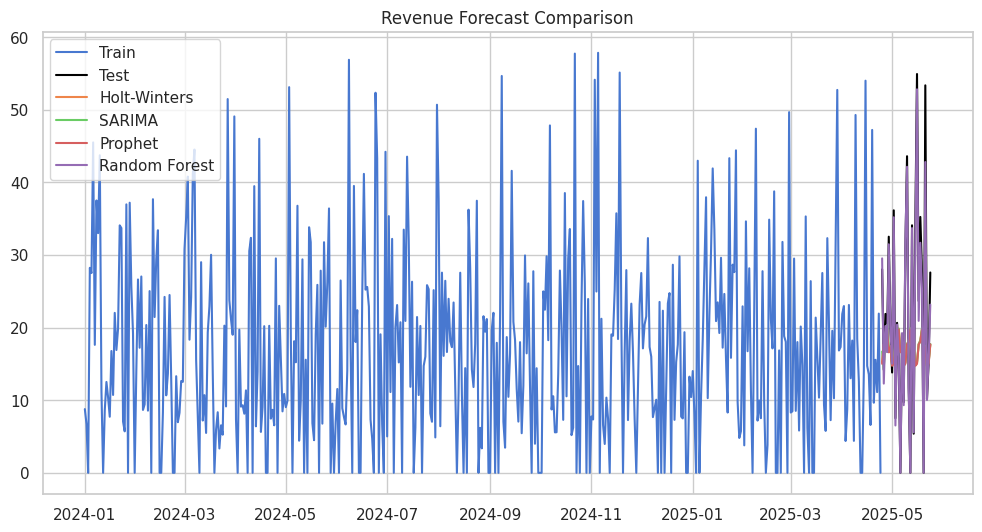

In [ ]:
# --- Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
from prophet import Prophet

# --- Load Data ---
df = pd.read_csv("/content/cleaned/taco_daily_aggregated.csv", parse_dates=["order_dt"])
df = df.rename(columns={"order_dt": "date"})
df = df.set_index("date").asfreq("D")

# Fill missing revenue values forward
df["revenue"] = df["revenue"].fillna(method="ffill")

# --- Train-Test Split ---
train = df.iloc[:-30]   # all but last 30 days
test  = df.iloc[-30:]   # last 30 days

results = {}

# Exponential Smoothing
hw = ExponentialSmoothing(train["revenue"], trend="add", seasonal="add", seasonal_periods=7)
hw_fit = hw.fit()
hw_forecast = hw_fit.forecast(30)
results["Holt-Winters"] = hw_forecast

# SARIMA
sarima = SARIMAX(train["revenue"], order=(1,1,1), seasonal_order=(1,1,1,7))
sarima_fit = sarima.fit(disp=False)
sarima_forecast = sarima_fit.forecast(30)
results["SARIMA"] = sarima_forecast

# Prophet
prophet_df = train.reset_index()[["date", "revenue"]].rename(columns={"date": "ds", "revenue": "y"})
prophet = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=False)
prophet.fit(prophet_df)
future = prophet.make_future_dataframe(periods=30)
prophet_forecast = prophet.predict(future).set_index("ds")["yhat"].iloc[-30:]
results["Prophet"] = prophet_forecast

# 4. Random Forest / Gradient Boosting (lag features) ---
from sklearn.ensemble import RandomForestRegressor

# Create lag features
lag_df = df.copy()
for lag in range(1, 8):
    lag_df[f"lag_{lag}"] = lag_df["revenue"].shift(lag)

lag_df = lag_df.dropna()
X = lag_df.drop("revenue", axis=1)
y = lag_df["revenue"]

X_train, X_test = X.iloc[:-30], X.iloc[-30:]
y_train, y_test = y.iloc[:-30], y.iloc[-30:]

rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
rf_forecast = pd.Series(rf.predict(X_test), index=y_test.index)
results["Random Forest"] = rf_forecast

# Evaluation
rows = []
for name, forecast in results.items():
    y_true = test["revenue"]
    y_pred = forecast
    mae = mean_absolute_error(y_true, y_pred)
    rmse = sqrt(mean_squared_error(y_true, y_pred))
    rows.append({"Model": name, "MAE": mae, "RMSE": rmse})

metrics_df = pd.DataFrame(rows).sort_values("RMSE").reset_index(drop=True)
print(metrics_df)

# Plot
plt.figure(figsize=(12,6))
plt.plot(train.index, train["revenue"], label="Train")
plt.plot(test.index, test["revenue"], label="Test", color="black")
for name, forecast in results.items():
    plt.plot(forecast.index, forecast, label=name)
plt.legend()
plt.title("Revenue Forecast Comparison")
plt.show()


   Order ID   Restaurant Name     Location           Order Time        Delivery Time  Delivery Duration (min)  \
0    770487      El Taco Loco     New York  2024-08-01 14:55:00  2024-08-01 15:36:00                       41   
1    671858      El Taco Loco  San Antonio  2024-11-23 17:11:00  2024-11-23 17:25:00                       14   
2    688508        Taco Haven       Austin  2024-11-21 20:24:00  2024-11-21 21:02:00                       38   
3    944962  Spicy Taco House       Dallas  2024-09-21 06:43:00  2024-09-21 07:28:00                       45   
4    476417     Casa del Taco  San Antonio  2024-07-24 11:01:00  2024-07-24 11:16:00                       15   

  Taco Size     Taco Type  Toppings Count  Distance (km)  Price ($)  Tip ($)  Weekend Order  order_date  \
0   Regular  Chicken Taco               5           3.01       9.25     2.22          False  2024-08-01   
1   Regular     Beef Taco               1           6.20       4.25     3.01           True  2024-11-23   


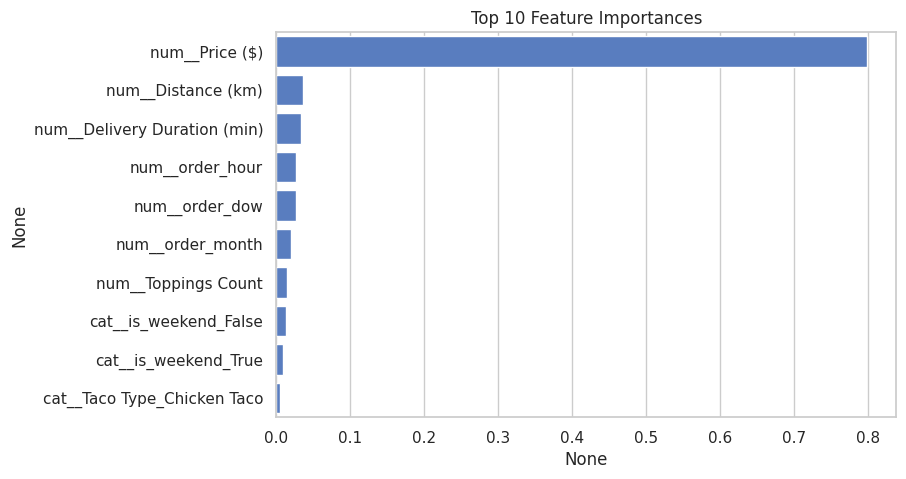

Optimal Price: $10.28, Expected Revenue: $12.14


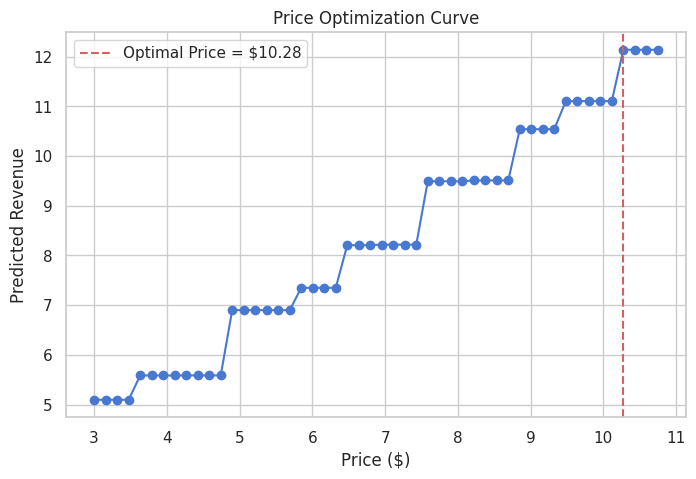

In [ ]:
#Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

#Load Dataset
df = pd.read_csv("/content/cleaned/taco_orders_clean.csv")

# Quick check
print(df.head())
print(df.info())

#Define Features & Target
features = [
    "Price ($)", "Toppings Count", "Taco Size", "Taco Type",
    "Distance (km)", "Delivery Duration (min)",
    "order_hour", "order_dow", "order_month", "is_weekend", "order_count"
]
target = "order_value"

X = df[features]
y = df[target]

#Preprocessing
# Separate categorical and numeric features
categorical = ["Taco Size", "Taco Type", "is_weekend"]
numeric = [col for col in features if col not in categorical]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical)
    ]
)

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest Regressor Pipeline
rf_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", RandomForestRegressor(n_estimators=200, random_state=42))
])

rf_model.fit(X_train, y_train)

#Evaluation
y_pred = rf_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Model Performance:")
print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.2f}")


# Feature Importance
model_only = rf_model.named_steps["model"]
preprocessor_only = rf_model.named_steps["preprocessor"]

# Get feature names after encoding
encoded_features = preprocessor_only.get_feature_names_out()
feature_importances = pd.Series(model_only.feature_importances_, index=encoded_features)

top_features = feature_importances.sort_values(ascending=False).head(10)

plt.figure(figsize=(8,5))
sns.barplot(x=top_features, y=top_features.index)
plt.title("Top 10 Feature Importances")
plt.show()

# Price Simulation (Optimization)
# Pick an average taco order profile
sample_order = X_test.iloc[[0]].copy()

price_range = np.linspace(df["Price ($)"].min(), df["Price ($)"].max(), 50)
predicted_revenues = []

for p in price_range:
    sample_order["Price ($)"] = p
    pred_revenue = rf_model.predict(sample_order)[0]
    predicted_revenues.append(pred_revenue)

# Find optimal price
optimal_price = price_range[np.argmax(predicted_revenues)]
max_revenue = max(predicted_revenues)

print(f"Optimal Price: ${optimal_price:.2f}, Expected Revenue: ${max_revenue:.2f}")

# Plot
plt.figure(figsize=(8,5))
plt.plot(price_range, predicted_revenues, marker="o")
plt.axvline(optimal_price, color="r", linestyle="--", label=f"Optimal Price = ${optimal_price:.2f}")
plt.xlabel("Price ($)")
plt.ylabel("Predicted Revenue")
plt.title("Price Optimization Curve")
plt.legend()
plt.show()


In [ ]:
!pip install prophet

import pandas as pd

# Load your cleaned taco orders file
df = pd.read_csv("/content/cleaned/taco_orders_clean.csv")

# Aggregate daily sales
df_daily = df.groupby("order_date").agg({
    "order_value": "sum"
}).reset_index()

# Prophet requires: ds (date), y (value to forecast)
df_prophet = df_daily.rename(columns={"order_date": "ds", "order_value": "y"})

from prophet import Prophet

model = Prophet(daily_seasonality=True, yearly_seasonality=True)
model.fit(df_prophet)

future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

# Save forecast to CSV
forecast.to_csv("forecast_sales.csv", index=False)

print("Forecast saved as forecast_sales.csv")



DEBUG:cmdstanpy:input tempfile: /tmp/tmp30_0_mom/67feong1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp30_0_mom/zuocjwy7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72235', 'data', 'file=/tmp/tmp30_0_mom/67feong1.json', 'init=/tmp/tmp30_0_mom/zuocjwy7.json', 'output', 'file=/tmp/tmp30_0_mom/prophet_modelcoosz25a/prophet_model-20250831045710.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:57:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:57:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Forecast saved as forecast_sales.csv


In [ ]:

# Load your forecast file
df = pd.read_csv("/content/forecast_sales.csv")

# Keep only useful columns
df_clean = df[["ds", "yhat", "yhat_lower", "yhat_upper", "trend", "weekly", "yearly"]].copy()

# Rename columns to business-friendly names
df_clean.rename(columns={
    "ds": "Date",
    "yhat": "Forecasted Sales",
    "yhat_lower": "Lower Bound",
    "yhat_upper": "Upper Bound",
    "trend": "Trend Component",
    "weekly": "Weekly Effect",
    "yearly": "Yearly Effect"
}, inplace=True)

# Save cleaned file for Power BI
df_clean.to_csv("forecast_sales_clean.csv", index=False)

print("Cleaned forecast file saved as 'forecast_sales_clean.csv'")


✅ Cleaned forecast file saved as 'forecast_sales_clean.csv'


In [ ]:
print(df.columns)

In [ ]:
import numpy as np
import pandas as pd

# Ensure data is available
# df should have: 'Price ($)' and 'order_count'
price_df = (
    df.groupby('Price ($)')
      .agg(orders=('order_count', 'sum'))
      .reset_index()
)

# Sort by price
price_df = price_df.sort_values('Price ($)').reset_index(drop=True)

# Calculate percentage changes in price and orders
price_df['pct_change_price'] = price_df['Price ($)'].pct_change()
price_df['pct_change_orders'] = price_df['orders'].pct_change()

# Elasticity = %ΔQ / %ΔP
price_df['elasticity'] = price_df['pct_change_orders'] / price_df['pct_change_price']

# Drop NaN from first row
elasticity_df = price_df.dropna().reset_index(drop=True)

# Save to CSV
elasticity_df.to_csv("price_elasticity.csv", index=False)

print(" price_elasticity.csv created with columns: Price ($), orders, pct_change_price, pct_change_orders, elasticity")


In [ ]:
kpi = {
    "total_orders": df['order_count'].sum(),
    "total_revenue": df['order_value'].sum(),
    "avg_order_value": df['order_value'].mean(),
    "avg_delivery_time": df['Delivery Duration (min)'].mean(),
    "unique_customers": df['Order ID'].nunique()
}

kpi_df = pd.DataFrame([kpi])
kpi_df.to_csv("kpi_summary.csv", index=False)


In [ ]:
from google.colab import files

files.download("historical_sales.csv")
files.download("forecast_sales.csv")
files.download("price_elasticity.csv")
files.download("kpi_summary.csv")
